# Human Pose Estimation - Part 3

# Person Detection using an Object Detector

## Download COCO Dataset

In [ ]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip'] # For Part 1, you won't need the train2017.zip

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping val2017.zip
Done transferring all datasets


## Download the Pre-Trained Model
Download a pretrained Faster R-CNN from torchvision to perform inference with it.

In [ ]:
# initialization
import numpy as np
import pandas as pd
import torch
import json
from PIL import Image
from scipy.io import loadmat
from matplotlib.pyplot import imshow, show
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
import torch
import torchvision

# load a model pre-trained pre-trained on COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model_faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 57.9MB/s]


### Inspect the Dataset Labels
Load the label mapping from id to category/name. We are only interested in a person detector, which corresponds to label_id=1

In [ ]:
# Show content of instances_val2017.json
instances = json.load(open('./annotations/instances_val2017.json','rb'))
print(instances.keys())

# Show all the categories
categories = instances['categories']
print(categories)

# Create two lookups between IDs and Categories
ids_to_cats = {v['id']: v['name'] for v in categories}
cats_to_ids = {v['name']: v['id'] for v in categories}

# find person label
PERSON_LABEL = cats_to_ids['person'] # should be 1
print(PERSON_LABEL)


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
1


[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 {'id': 17, 'name': 'cat', 'supercategory': 'animal'},
 {'id': 18, 'name': 'dog', 'supercategory': 'animal'},

### Perform Inference on Test Images
1. Load an image from the given `img_path`
2. Perform inference on the image for object detection
3. Plot the original image and bounding boxes of the label indicated by `label_to_detect` (default: person label)

In [ ]:
'''
detect_object_fastercnn

This function will perform inference on the fastercnn model to get back the
labels, scores, and bounding boxes for each object detected in the image.
It will then filter only the objects with label as `label_to_detect`
and plot the corresponding bounding boxes on the original image as long as
the detected object has a score > `score_threshold`

'''
import time
def detect_object_fastercnn(img_path, label_to_detect=PERSON_LABEL, score_threshold=0.75, model=model_faster_rcnn, device='cuda',input_width=192, input_height=256):
    
    # put model into eval mode
    model = model.to(device)
    model.eval()
    
    # Open the Image
    img = Image.open(img_path)

    # Generate the input tensor and normalize
    img_tensor = torch.tensor(np.asarray(img)).permute(2,0,1).unsqueeze(0)
    img_tensor = img_tensor.float()/255.0 # Cast & Normalize
    img_tensor = img_tensor.to(device)
     
    # Do inference
    start = time.time()
    with torch.no_grad():
        predictions = model(img_tensor)
    end = time.time()
    print("Inference time: ", end-start)

    # Get the bounding boxes of the relevant objects
    object_indices = (predictions[0]['labels'] == label_to_detect).nonzero()
    boxes = predictions[0]['boxes'][object_indices].int().cpu().numpy()
    scores = predictions[0]['scores'][object_indices].cpu().numpy()
    num_objects_detected = boxes.shape[0]

    # For each object box, plot the bounding-box on the original image:
    displayed_objects = 0
    colors = ["blue", "green", "red", "pink","yellow"]
    for i in range(num_objects_detected):
        if scores[i][0] > score_threshold:
            displayed_objects += 1
          
            # Plot the original Image with the bounding box
            fig = plt.figure(i,figsize=(14, 6))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(img)   
            
            # draw bounding box
            x_start, y_start, x_end, y_end = boxes[i][0]
            color = colors[i % len(colors)]
            ax1.add_patch(Rectangle((x_start, y_start), x_end-x_start, y_end-y_start, alpha=0.35, facecolor=color, edgecolor=color, hatch='x'))

            # Rescale Input Image
            rescaled_img = img.resize((input_width,input_height), box=(x_start, y_start, x_end, y_end))
            rescaled_img = np.array(rescaled_img)

            # show rescaled Input Image
            ax2 = fig.add_subplot(1, 2, 2)
            ax2.imshow(rescaled_img)   
            
    print('---------------------------------------------')
    print("Detected", displayed_objects, "objects with score >", score_threshold)
    print('---------------------------------------------')

    plt.show()
    img.close()


In [ ]:
# Detect people in a few test images
img_paths = ['./val2017/000000000139.jpg', './val2017/000000002473.jpg', './val2017/000000025393.jpg']

for img_path in img_paths:
    detect_object_fastercnn(img_path, label_to_detect=PERSON_LABEL) # PERSON_LABEL=1

Output hidden; open in https://colab.research.google.com to view.

Inference time:  0.44050073623657227
---------------------------------------------
Detected 3 objects with score > 0.75
---------------------------------------------


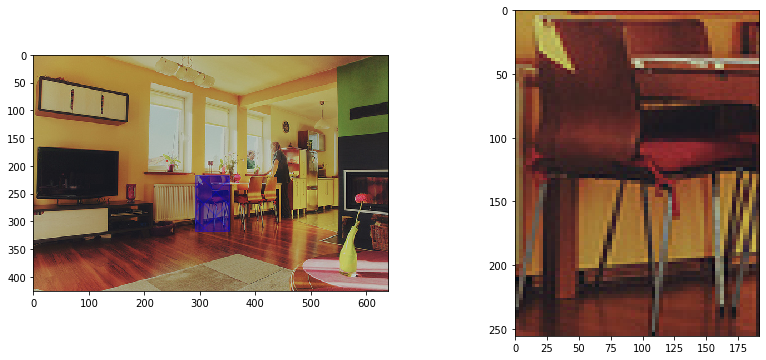

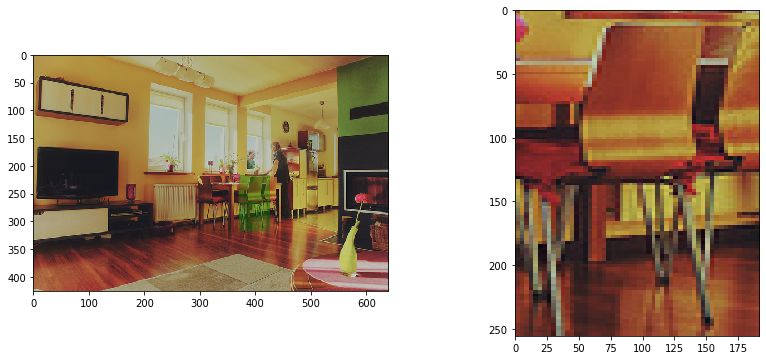

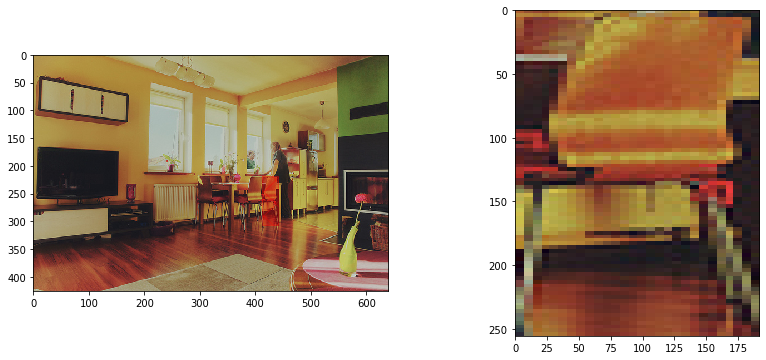

Inference time:  0.36163330078125
---------------------------------------------
Detected 1 objects with score > 0.75
---------------------------------------------


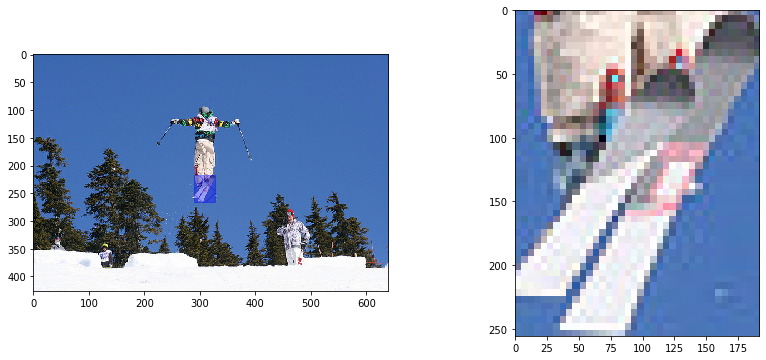

Inference time:  0.32144927978515625
---------------------------------------------
Detected 2 objects with score > 0.75
---------------------------------------------


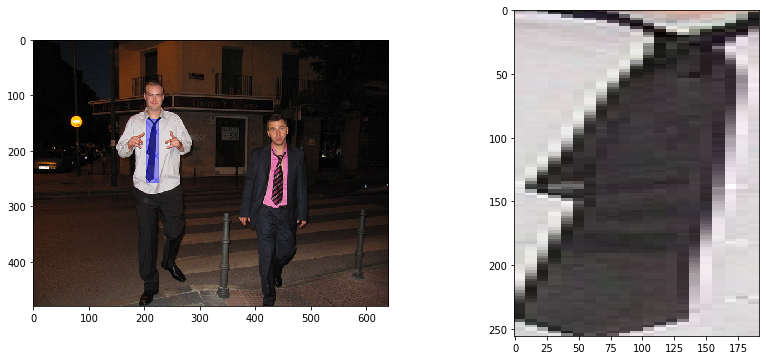

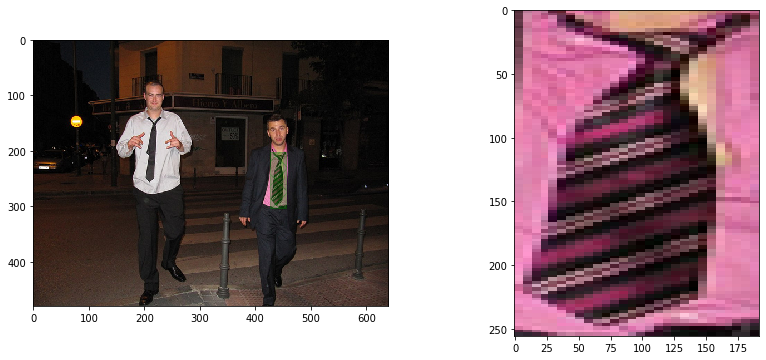

In [ ]:
# Change the label just for fun; chair=62, skies=35,tie=32
detect_object_fastercnn(img_paths[0], label_to_detect=cats_to_ids['chair']) # chairs
detect_object_fastercnn(img_paths[1], label_to_detect=cats_to_ids['skis']) # skis
detect_object_fastercnn(img_paths[2], label_to_detect=cats_to_ids['tie']) # ties